<a href="https://colab.research.google.com/github/LarisYas/ProjectML/blob/master/%D0%A0%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Задача классификации текста

### 1.1 Скачиваем данные и смотрим на них

In [1]:
from torchtext.datasets import AG_NEWS
from collections import defaultdict

train_data, test_data = AG_NEWS("agnews")

print("Train size:", len(train_data))
print("Test size:", len(test_data))

print(next(iter(train_data)))

Train size: 120000
Test size: 7600
(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


Посмотрим на распределение классов и по случайному примеру от каждого.

In [2]:
from collections import defaultdict
from pprint import pprint

def count_classes(dataset):
    n_classes = defaultdict(int)
    sample_by_class = {}
    for label, text in dataset:
        n_classes[label] += 1
        sample_by_class[label] = text
    pprint(n_classes)
    pprint(sample_by_class)

count_classes(train_data)
print()
count_classes(test_data)

defaultdict(<class 'int'>, {3: 29999, 4: 30000, 2: 30000, 1: 30000})
{1: "Pakistan's Musharraf Says Won't Quit as Army Chief  KARACHI (Reuters) - "
    'Pakistani President Pervez Musharraf  has said he will stay on as army '
    'chief, reneging on a pledge to  quit the powerful post by the end of the '
    'year.',
 2: 'Nets get Carter from Raptors INDIANAPOLIS -- All-Star Vince Carter was '
    'traded by the Toronto Raptors to the New Jersey Nets for Alonzo Mourning, '
    'Eric Williams, Aaron Williams, and a pair of first-round draft picks '
    'yesterday.',
 3: 'Murdoch will shell out \\$44 mil. for Manhattan penthouse NEW YORK -- '
    'Rupert Murdoch, the billionaire CEO of News Corp., has reportedly offered '
    'to buy a three-story penthouse for \\$44 million, which would be the '
    'highest price ever paid for a Manhattan by about \\$1.75 million if the '
    'deal goes through.',
 4: 'Compromise seals climate meeting A climate conference overcomes '
    'last-minute o

In [3]:
# Исходные датасеты съедены, загрузим их снова
train_data, test_data = AG_NEWS("agnews")
train_data = list(train_data)
test_data = list(test_data)

### 1.2 Готовим данные.

In [4]:
import itertools
from typing import Mapping
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


# Построим токенизацию алглийского текста
tokenizer = get_tokenizer('basic_english')
vocab: Mapping[str, int] = build_vocab_from_iterator(
    (tokenizer(text) for _, text in itertools.chain(train_data, test_data)),
    min_freq=1,
    specials=["<unk>", "<pad>"]
)
vocab.set_default_index(vocab["<unk>"])
print(len(vocab))

98636


In [5]:
for token in ["alive", "is", "33", "<unk>", "<pad>"]:
    print(token, vocab[token])

alive 2355
is 22
33 2910
<unk> 0
<pad> 1


In [7]:
# Пригодится узнать максимальную длину текста
max_text_len = max(len(tokenizer(text)) for _, text in itertools.chain(train_data, test_data))
max_text_len

207

Далее будем делать батчи.

In [8]:
import torch

# Превращаем всё в числа
preprocess_text = lambda x: vocab(tokenizer(x))
preprocess_label = lambda x: x - 1


def collate_batch_offsets(batch):
    """Применение предварительной обработки со смещениями к батчу."""
    label_list, text_list, offsets = [], [], [0]
    for (label, text) in batch:
        label_list.append(preprocess_label(label))
        processed_text = torch.tensor(preprocess_text(text),
                                      dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(len(processed_text))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.cat(text_list)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    return label_list, text_list, offsets


def collate_batch_padding(batch):
    """Применение предварительной обработки с padding-ом к батчу."""
    label_list, text_list = [], []
    for (label, text) in batch:
        label_list.append(preprocess_label(label))
        processed_text = preprocess_text(text)
        processed_text = processed_text + [vocab["<pad>"]] * (max_text_len - len(processed_text))
        text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.tensor(text_list, dtype=torch.int64)
    return label_list, text_list

In [9]:
# Готовим даталоадеры
from torch.utils.data import DataLoader

train_loader = {}
test_loader = {}

for method, collate_fn in [("offset", collate_batch_offsets), ("padding", collate_batch_padding)]:
    train_loader[method] = DataLoader(train_data, batch_size=48, shuffle=True, drop_last=True, collate_fn=collate_fn)
    test_loader[method] = DataLoader(test_data, batch_size=48, shuffle=False, drop_last=False, collate_fn=collate_fn)
    

Проверим размеры элементов батча.

In [10]:
for l_, t_, o_ in train_loader["offset"]:
    print(f'labels ~ {l_.shape}\n{l_}\n')
    print(f'texts ~ {t_.shape}\n{t_}\n')
    print(f'offsets ~ {o_.shape}\n{o_}')
    break

labels ~ torch.Size([48])
tensor([0, 3, 1, 0, 0, 0, 1, 1, 2, 1, 2, 1, 0, 0, 0, 1, 1, 2, 0, 0, 2, 2, 0, 0,
        1, 0, 1, 1, 2, 1, 1, 0, 1, 0, 3, 2, 3, 1, 3, 0, 1, 3, 0, 2, 0, 0, 1, 1])

texts ~ torch.Size([2090])
tensor([  171, 10320,  2292,  ...,   937,  4011,     2])

offsets ~ torch.Size([48])
tensor([   0,   20,   55,   96,  147,  177,  211,  265,  316,  363,  398,  448,
         485,  525,  588,  624,  665,  709,  752,  803,  846,  886,  925,  977,
        1053, 1088, 1147, 1189, 1235, 1286, 1334, 1380, 1410, 1457, 1502, 1535,
        1574, 1612, 1651, 1705, 1734, 1766, 1817, 1856, 1898, 1946, 1997, 2056])


In [11]:
for l_, t_ in train_loader["padding"]:
    print(f'labels ~ {l_.shape}\n{l_}\n')
    print(f'texts ~ {t_.shape}\n{t_}\n')
    break

labels ~ torch.Size([48])
tensor([1, 2, 2, 2, 3, 3, 3, 1, 2, 3, 0, 0, 1, 2, 2, 2, 0, 1, 3, 2, 1, 1, 0, 2,
        1, 2, 0, 0, 2, 3, 0, 2, 3, 0, 1, 2, 3, 2, 1, 2, 0, 3, 1, 1, 1, 1, 0, 3])

texts ~ torch.Size([48, 207])
tensor([[   13,   243, 39797,  ...,     1,     1,     1],
        [ 3087,   561, 16626,  ...,     1,     1,     1],
        [  873,    23,  1687,  ...,     1,     1,     1],
        ...,
        [ 3629,  9460,  4094,  ...,     1,     1,     1],
        [  323,   461,   660,  ...,     1,     1,     1],
        [ 4282,   332,   743,  ...,     1,     1,     1]])



## 2. Составляем модель.

### 2.1 Рекуррентная модель

In [12]:
from torch import nn

class RecurrentModel(nn.Module):
    """
        Network with recurrent block
    """
    def __init__(self, vocab_size, input_size, hidden_size, output_size, rnn_type,
                 num_layers, bidirectional, dropout_p, reduce='last'):
        super(RecurrentModel, self).__init__()
        self.rnn_type = rnn_type
        D = 2 if bidirectional else 1
        self.reduce = reduce
        
        rnn_types = [nn.RNN, nn.LSTM, nn.GRU]
        assert rnn_type in rnn_types
        
        reduce_ways = ['last', 'max', 'mean', 'sum']
        assert reduce in reduce_ways
        
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=input_size)
        
        self.rnn_layers = rnn_type(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout_p,
            batch_first=True
        )
        
        self.to_class = nn.Linear(D*hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, texts):
        texts = self.embed(texts % self.embed.num_embeddings)
        
        if self.rnn_type == nn.LSTM:
            output, (hn, cn) = self.rnn_layers(texts)
        else:
            output, hn = self.rnn_layers(texts)
        
        # print(output.shape)
        if self.reduce == 'last':
            output = output[..., -1, :]
        elif self.reduce == 'mean':
            output = output.mean(-2)
        elif self.reduce == 'max':
            output = output.max(-2)
        elif self.reduce == 'sum':
            output = output.sum(-2)
        
        # print(output.shape)
        return self.softmax(self.to_class(output))

Для интереса посмотрим, сколько параметров содержат разные рекуррентные модели.

In [13]:
hashing_trick_size = 5000
num_classes = 4

model_rnn = RecurrentModel(
    vocab_size = hashing_trick_size,
    input_size = 500,
    hidden_size = 100,
    output_size = num_classes,
    rnn_type = nn.RNN,
    num_layers = 3,
    bidirectional = True,
    dropout_p = 0.3,
    reduce = 'last'
)

print('Model:', model_rnn, sep='\n')

labels_batch, texts_batch = next(iter(train_loader["padding"]))

print(f'\nInput shape: {texts_batch.shape}')
out = model_rnn(texts_batch % hashing_trick_size)
print(f'Output shape: {out.shape}')

print(f'\nChecking that returned probabilities (all sums must be close to 1)',
      out.sum(-1).detach().numpy(), sep='\n')

Model:
RecurrentModel(
  (embed): Embedding(5000, 500)
  (rnn_layers): RNN(500, 100, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (to_class): Linear(in_features=200, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

Input shape: torch.Size([48, 207])
Output shape: torch.Size([48, 4])

Checking that returned probabilities (all sums must be close to 1)
[1.         1.0000001  1.         1.         1.         0.99999994
 1.         1.         0.99999994 1.         1.         1.
 0.99999994 1.         0.99999994 1.         0.99999994 0.99999994
 1.         1.         1.         1.         1.         1.
 0.99999994 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.99999994 1.         0.99999994 1.         1.
 1.         1.0000001  1.         1.         1.         0.99999994]


In [14]:
def model_num_params(model):
  """Показывает количество параметров."""
    sum_params = 0
    for name, weights in model.named_parameters():
        print(f'{name: <19} ~  {weights.numel(): <7} params')
        sum_params += weights.numel()
    print(f'\nIn total: {sum_params} params')
    return sum_params

sum_params = model_num_params(model_rnn)

embed.weight        ~  2500000 params
rnn_layers.weight_ih_l0 ~  50000   params
rnn_layers.weight_hh_l0 ~  10000   params
rnn_layers.bias_ih_l0 ~  100     params
rnn_layers.bias_hh_l0 ~  100     params
rnn_layers.weight_ih_l0_reverse ~  50000   params
rnn_layers.weight_hh_l0_reverse ~  10000   params
rnn_layers.bias_ih_l0_reverse ~  100     params
rnn_layers.bias_hh_l0_reverse ~  100     params
rnn_layers.weight_ih_l1 ~  20000   params
rnn_layers.weight_hh_l1 ~  10000   params
rnn_layers.bias_ih_l1 ~  100     params
rnn_layers.bias_hh_l1 ~  100     params
rnn_layers.weight_ih_l1_reverse ~  20000   params
rnn_layers.weight_hh_l1_reverse ~  10000   params
rnn_layers.bias_ih_l1_reverse ~  100     params
rnn_layers.bias_hh_l1_reverse ~  100     params
rnn_layers.weight_ih_l2 ~  20000   params
rnn_layers.weight_hh_l2 ~  10000   params
rnn_layers.bias_ih_l2 ~  100     params
rnn_layers.bias_hh_l2 ~  100     params
rnn_layers.weight_ih_l2_reverse ~  20000   params
rnn_layers.weight_hh_l2_reve

In [15]:
# Теперь посмотрим сколько параметро содержит LSTM
model_lstm = RecurrentModel(
    vocab_size = hashing_trick_size,
    input_size = 500,
    hidden_size = 100,
    output_size = num_classes,
    rnn_type = nn.LSTM,
    num_layers = 3,
    bidirectional = False,
    dropout_p = 0.3,
    reduce = 'last'
)

print('Model:', model_lstm, sep='\n')

labels_batch, texts_batch = next(iter(train_loader["padding"]))

print(f'\nInput shape: {texts_batch.shape}')
out = model_lstm(texts_batch % hashing_trick_size)
print(f'Output shape: {out.shape}')

print(f'\nChecking that returned probabilities (all sums must be close to 1)',
      out.sum(-1).detach().numpy(), sep='\n')

Model:
RecurrentModel(
  (embed): Embedding(5000, 500)
  (rnn_layers): LSTM(500, 100, num_layers=3, batch_first=True, dropout=0.3)
  (to_class): Linear(in_features=100, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

Input shape: torch.Size([48, 207])
Output shape: torch.Size([48, 4])

Checking that returned probabilities (all sums must be close to 1)
[1.         1.0000001  0.99999994 1.         1.         0.9999999
 0.99999994 1.         0.99999994 1.0000001  0.99999994 0.99999994
 1.         1.         1.         0.9999999  0.9999999  1.
 1.         1.         0.9999999  1.         1.         1.
 1.         1.         1.         1.0000001  1.         1.
 0.99999994 0.99999994 0.9999999  1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.99999994]


In [16]:
sum_params = model_num_params(model_lstm)

embed.weight        ~  2500000 params
rnn_layers.weight_ih_l0 ~  200000  params
rnn_layers.weight_hh_l0 ~  40000   params
rnn_layers.bias_ih_l0 ~  400     params
rnn_layers.bias_hh_l0 ~  400     params
rnn_layers.weight_ih_l1 ~  40000   params
rnn_layers.weight_hh_l1 ~  40000   params
rnn_layers.bias_ih_l1 ~  400     params
rnn_layers.bias_hh_l1 ~  400     params
rnn_layers.weight_ih_l2 ~  40000   params
rnn_layers.weight_hh_l2 ~  40000   params
rnn_layers.bias_ih_l2 ~  400     params
rnn_layers.bias_hh_l2 ~  400     params
to_class.weight     ~  400     params
to_class.bias       ~  4       params

In total: 2902804 params


### 2.2 Оптимизатор

In [17]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def create_model_and_optimizer(model_class, model_params, lr=1e-3, beta1=0.9, beta2=0.999, device=device):
    model = model_class(**model_params)
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr, [beta1, beta2])
    return model, optimizer

In [18]:
model_params = {
    'vocab_size': hashing_trick_size,
    'input_size': 500,
    'hidden_size': 100,
    'output_size': num_classes,
    'rnn_type': nn.RNN,
    'num_layers': 3,
    'bidirectional': True,
    'dropout_p': 0.3,
    'reduce': 'last'
}

model, optimizer = create_model_and_optimizer(
    model_class = RecurrentModel, 
    model_params = model_params,
    lr = 1e-3,
)

### 2.3 Обучение и валидация одной эпохи.

In [19]:
import torch.nn.functional as F
from tqdm.notebook import tqdm

criterion = nn.CrossEntropyLoss()

def train(model, optimizer, loader, criterion):
    model.train()  # !
    losses_tr = []
    for labels, texts in tqdm(loader):
        labels = labels.to(device)
        texts = texts.to(device)
        
        optimizer.zero_grad()
        out = model(texts)
        loss = criterion(out, labels)
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())  # Обратите внимание, что вызов .item() позволяет не сохранять лоссы на device (https://github.com/PyTorchLightning/pytorch-lightning/issues/4556)
    
    return model, optimizer, np.mean(losses_tr)

def val(model, loader, criterion):
    model.eval()  # !
    losses_val = []
    with torch.no_grad():  # !
        for labels, texts in tqdm(loader):
            labels = labels.to(device)
            texts = texts.to(device)
            out = model(texts)
            loss = criterion(out, labels)

            losses_val.append(loss.item())
    
    return np.mean(losses_val)

### 2.4 Цикл обучения

In [20]:
from IPython.display import clear_output
from tqdm.notebook import trange
import matplotlib.pyplot as plt
%matplotlib inline


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def learning_loop(model, optimizer, train_loader, val_loader, criterion, scheduler=None, min_lr=None,
                  epochs=10, val_every=1, draw_every=1, separate_show=False):
    losses = {'train': [], 'val': []}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if epoch % val_every == 0:
            loss = val(model, val_loader, criterion)
            losses['val'].append(loss)
            if scheduler:  # Scheduler позволяет управлять lr'ом на основе выбранной стратегии (https://pytorch.org/docs/stable/optim.html?highlight=scheduler#how-to-adjust-learning-rate)
                scheduler.step(loss)

        if epoch % draw_every == 0:
            clear_output(True)
            fig, ax = plt.subplots(1, 2 if separate_show else 1, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            if separate_show:
                plt.subplot(121)
                plt.title('loss on train')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.legend()

            if separate_show:
                plt.subplot(122)
                plt.title('loss on validation')
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses

### 2.5 Обучаем модели. Сначала двухслойную RNN.

In [21]:
model_params = dict()
model = dict()
optimizer = dict()
scheduler = dict()
criterion = dict()
losses = dict()

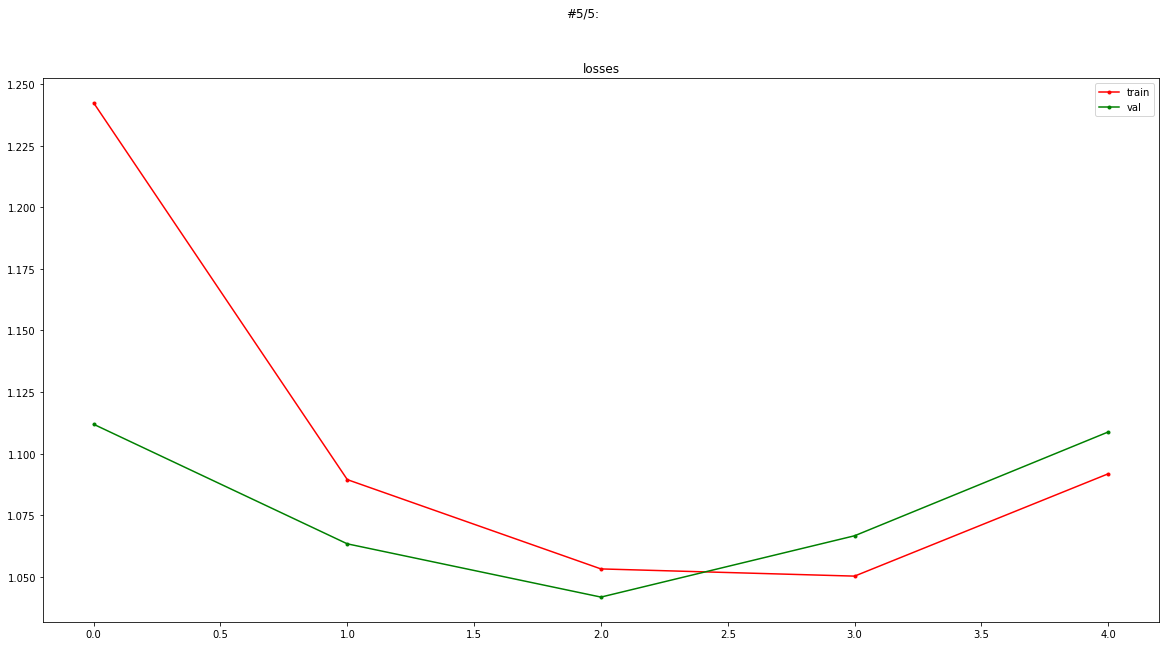

CPU times: user 8min 6s, sys: 4.77 s, total: 8min 10s
Wall time: 8min 19s


In [22]:
%%time
import numpy as np

model_type = 'bi-rnn'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params[model_type] = {
    'vocab_size': hashing_trick_size,
    'input_size': 100,
    'hidden_size': 20,
    'output_size': num_classes,
    'rnn_type': nn.RNN,
    'num_layers': 2,
    'bidirectional': True,
    'dropout_p': 0.3,
    'reduce': 'mean'
}

model[model_type], optimizer[model_type] = create_model_and_optimizer(
    model_class = RecurrentModel, 
    model_params = model_params[model_type],
    lr = 5e-4,
    device = device,
)

scheduler[model_type] = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer[model_type],
    mode='min',
    factor=0.25,
    patience=4,
    threshold=0.001,
    verbose=True
)

criterion[model_type] = nn.CrossEntropyLoss()

model[model_type], optimizer[model_type], losses[model_type] = learning_loop(
    model = model[model_type],
    optimizer = optimizer[model_type],
    train_loader = train_loader["padding"],
    val_loader = test_loader["padding"],
    criterion = criterion[model_type],
    scheduler = scheduler[model_type],
    epochs = 5,
    min_lr = 2e-6
)


### 2.6 Теперь обучаем модель LSTM.

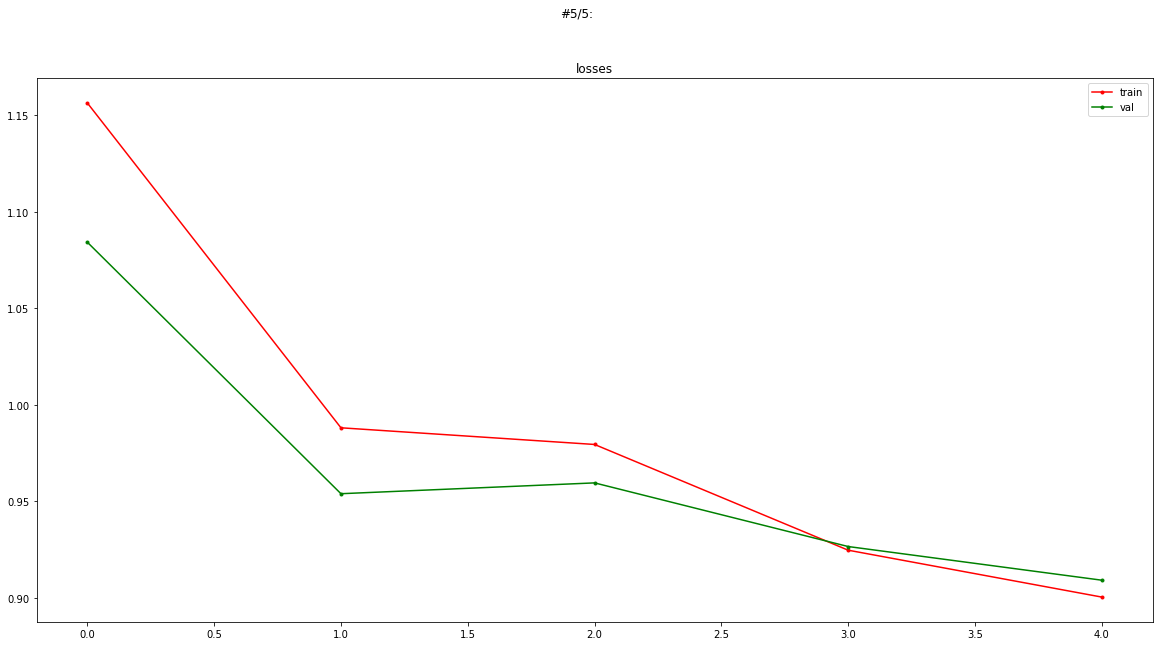

In [24]:
model_type = 'lstm'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params[model_type] = {
    'vocab_size': hashing_trick_size,
    'input_size': 100,
    'hidden_size': 20,
    'output_size': num_classes,
    'rnn_type': nn.LSTM,
    'num_layers': 2,
    'bidirectional': True,
    'dropout_p': 0.3,
    'reduce': 'mean'
}

model[model_type], optimizer[model_type] = create_model_and_optimizer(
    model_class = RecurrentModel, 
    model_params = model_params[model_type],
    lr = 5e-4,
    device = device,
)

scheduler[model_type] = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer[model_type],
    mode='min',
    factor=0.25,
    patience=4,
    threshold=0.001,
    verbose=True
)

criterion[model_type] = nn.CrossEntropyLoss()

model[model_type], optimizer[model_type], losses[model_type] = learning_loop(
    model = model[model_type],
    optimizer = optimizer[model_type],
    train_loader = train_loader["padding"],
    val_loader = test_loader["padding"],
    criterion = criterion[model_type],
    scheduler = scheduler[model_type],
    epochs = 5,
    min_lr = 2e-6
)

### 2.7 Теперь обучаем GRU.

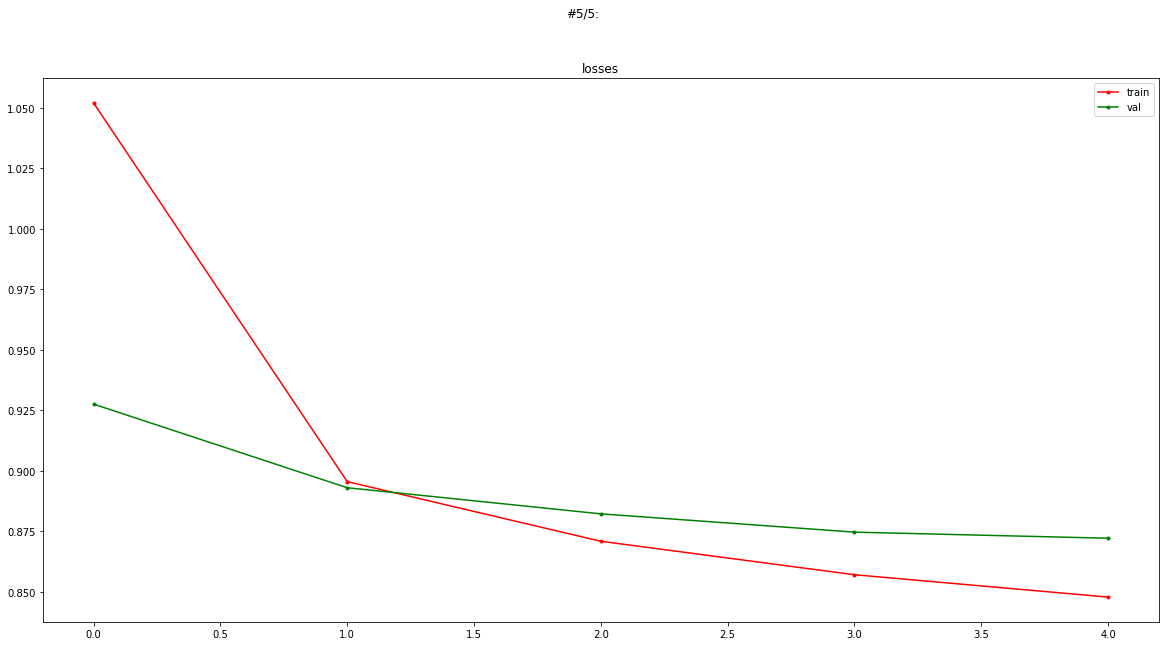

In [25]:
model_type = 'gru'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params[model_type] = {
    'vocab_size': hashing_trick_size,
    'input_size': 100,
    'hidden_size': 20,
    'output_size': num_classes,
    'rnn_type': nn.GRU,
    'num_layers': 2,
    'bidirectional': True,
    'dropout_p': 0.3,
    'reduce': 'mean'
}

model[model_type], optimizer[model_type] = create_model_and_optimizer(
    model_class = RecurrentModel, 
    model_params = model_params[model_type],
    lr = 5e-4,
    device = device,
)

scheduler[model_type] = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer[model_type],
    mode='min',
    factor=0.25,
    patience=4,
    threshold=0.001,
    verbose=True
)

criterion[model_type] = nn.CrossEntropyLoss()

model[model_type], optimizer[model_type], losses[model_type] = learning_loop(
    model = model[model_type],
    optimizer = optimizer[model_type],
    train_loader = train_loader["padding"],
    val_loader = test_loader["padding"],
    criterion = criterion[model_type],
    scheduler = scheduler[model_type],
    epochs = 5,
    min_lr = 2e-6
)